## Setup

In [11]:
# change into the src directory
import git
import os

repo = git.Repo('.', search_parent_directories=True)
os.chdir(repo.working_tree_dir)

In [12]:
from tapas_gmm.policy.models.tpgmm import ModelType, TPGMM, ReconstructionStrategy, FittingStage, InitStrategy, _xdx_to_tangent, TPGMMConfig, AutoTPGMMConfig, AutoTPGMM, FrameSelectionConfig, DemoSegmentationConfig, CascadeConfig
# import lovely_tensors as lt
# lt.monkey_patch()
from lovely_numpy import lo
import matplotlib.pyplot as plt

import pathlib
#from pbdlib.utils.jupyter_utils import *
import numpy as np

from conf._machine import data_naming_config as machine_data_naming_config
from tapas_gmm.dataset.demos import Demos, PartialFrameViewDemos
import tapas_gmm.policy.models.tpgmm
from tapas_gmm.utils.misc import load_scene_data, DataNamingConfig
from tapas_gmm.utils.logging import setup_logger  # noqa: F401
from tapas_gmm.viz.gmm import plot_log_map_quaternions, plot_hmm_transition_matrix

%matplotlib inline

%load_ext autoreload
%autoreload 2

data_root = pathlib.Path(machine_data_naming_config.data_root).resolve()
data_root = data_root.parent / data_root.stem

np.set_printoptions(precision=2)

plt.style.use('default')

from IPython.display import HTML
from matplotlib import rc
rc('animation', html='jshtml')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
#task = 'TurnOnLight'
serie = 'demos'
task = 'MoveToCabinetLeft'
path = data_root / task / serie

data_config = DataNamingConfig(
    feedback_type=None,
    task=None,
    data_root=None,
    path=path,
)

scene_data = load_scene_data(data_config)
print(scene_data.sample_data_point_with_ground_truth(cam="wrist"))


SingleCamSceneObservation(
    action=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    depth=Tensor(shape=torch.Size([256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
    ee_pose=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    extr=Tensor(shape=torch.Size([4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
    feedback=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
    intr=Tensor(shape=torch.Size([3, 3]), device=cpu, dtype=torch.float32, is_shared=False),
    mask=Tensor(shape=torch.Size([256, 256]), device=cpu, dtype=torch.uint8, is_shared=False),
    object_poses=TensorDict(
        fields={
            obj000: Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
            obj001: Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
            obj002: Tensor(shape=torch.Size([7]), device=cpu, dtype

In [14]:
gt_pose_config = {
    #'indeces': [1,2,3,4],
}

gt_kp_config = {
    'encoder_name': 'demos_keypoints_gt_encoder-world',
    'cam': 'front',
}

kp_config = {
    'encoder_name': 'demos_vit_keypoints_encoder',
    'encoding_name': 'gtcopy',
}


In [15]:
observations = scene_data.get_demos(**gt_pose_config)
print(observations[0].keys())
print(observations[0])
n_obs = len(observations)

demo_meta_data = {
    'path': path
}

data_kwargs = dict(
    meta_data=demo_meta_data,
    add_init_ee_pose_as_frame=True,
    add_world_frame=False,
    frames_from_keypoints=False,
    kp_indeces=None,
    enforce_z_up=False,
    modulo_object_z_rotation=False,
    make_quats_continuous=True
)

demos = Demos(observations, **data_kwargs)
print(demos)

_LazyStackedTensorDictKeysView(['action', 'cameras', 'ee_pose', 'feedback', 'gripper_state', 'joint_pos', 'joint_vel', 'object_poses', 'object_states'],
    include_nested=False,
    leaves_only=False)
SceneObservation(
    action=Tensor(shape=torch.Size([116, 7]), device=cpu, dtype=torch.float32, is_shared=False),
    cameras=LazyStackedTensorDict(
        fields={
            _order: CameraOrder(
                order=('wrist',),
                batch_size=torch.Size([116]),
                device=None,
                is_shared=False),
            wrist: SingleCamObservation(
                depth=Tensor(shape=torch.Size([116, 256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
                extr=Tensor(shape=torch.Size([116, 4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
                intr=Tensor(shape=torch.Size([116, 3, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                rgb=Tensor(shape=torch.Size([116, 3, 256, 256]), device=cpu, dt

In [16]:
tag="release"

tpgmm_config = TPGMMConfig(
    n_components=10,
    model_type=ModelType.HMM,
    use_riemann=True,
    add_time_component=True,
    add_action_component=False,
    position_only=False,  # Use rotation aswell?
    add_gripper_action=True,
    heal_time_variance=False,
    reg_shrink=1e-2, # 1e-2 is 0.01
    reg_diag=2e-4,
    reg_diag_gripper=2e-2,
    reg_em_finish_shrink=1e-2,
    reg_em_finish_diag=2e-4,
    reg_em_finish_diag_gripper=2e-2,

    em_steps=50,
)

frame_selection_config = FrameSelectionConfig(
    init_strategy=InitStrategy.TIME_BASED,
    fitting_actions=(FittingStage.INIT,),
    rel_score_threshold=0.75,
    use_bic=False, #Does prune segmentation
    drop_redundant_frames=True,

)

demos_segmentation_config = DemoSegmentationConfig(
    gripper_based=False,
    distance_based=False,
    velocity_based=True,
    velocity_threshold=0.001,
    components_prop_to_len=True,
    min_end_distance=10,
)

cascade_config = CascadeConfig()

auto_tpgmm_config = AutoTPGMMConfig(
    tpgmm=tpgmm_config,
    frame_selection=frame_selection_config,
    demos_segmentation=demos_segmentation_config,
    cascade=cascade_config,
)

In [17]:
atpgmm = AutoTPGMM(auto_tpgmm_config)


2025-06-16 21:38:40.861 | INFO     |  Fitting AutoTPGMM
2025-06-16 21:38:40.861 | INFO     |  Segmenting trajectories


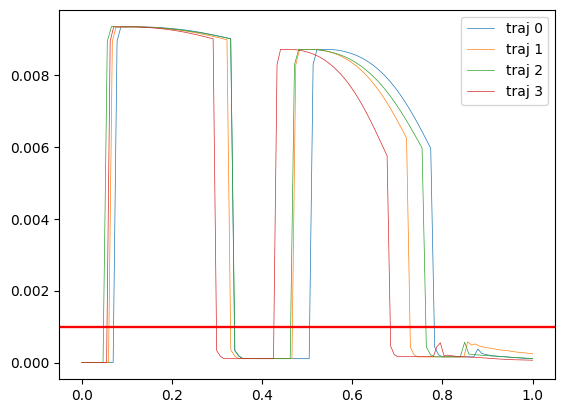

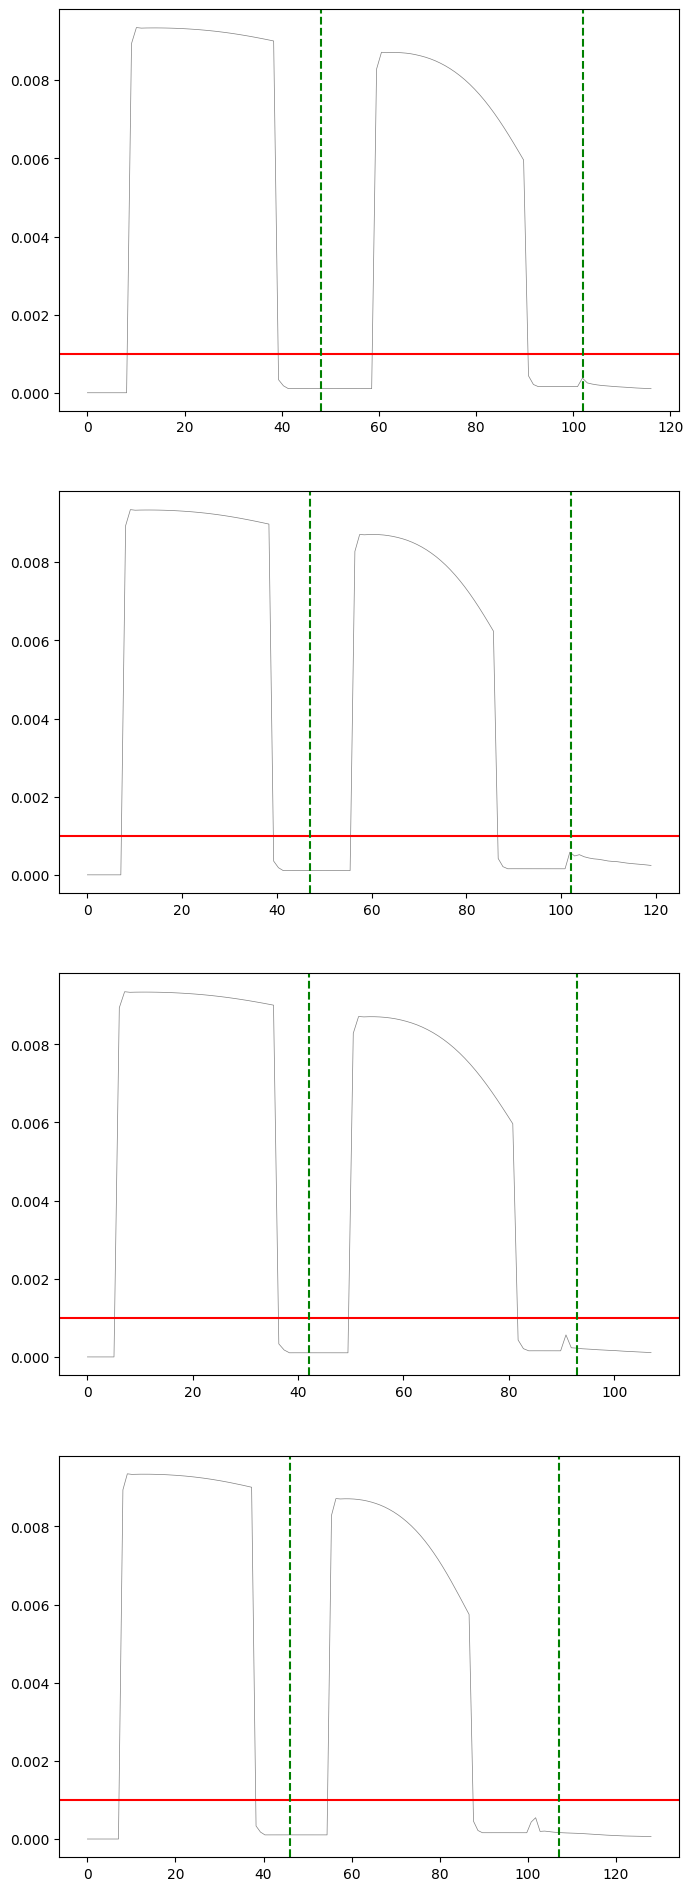

2025-06-16 21:38:41.553 | INFO     |  Creating segement of demos.
2025-06-16 21:38:41.564 | INFO     |  Creating segement of demos.
2025-06-16 21:38:41.574 | INFO     |  Subsampling to length 64 using strategy mean-length.
2025-06-16 21:38:41.575 | INFO     |  Creating segement of demos.
2025-06-16 21:38:41.583 | INFO     |  Subsampling to length 25 using strategy mean-length.
2025-06-16 21:38:41.585 | INFO     |  ... created 3 segments
2025-06-16 21:38:41.585 | INFO     |    Fitting candidate frame 1/10
2025-06-16 21:38:41.585 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-16 21:38:41.783 | INFO     |    Fitting candidate frame 2/10
2025-06-16 21:38:41.784 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-16 21:38:41.983 | INFO     |    Fitting candidate frame 3/10
2025-06-16 21:38:41.983 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-16 21:38:42.238 | INFO     |    Fitting candidate frame 4/10
2025-06-16 21:38:42.239 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-16 21:38:42.461 | INFO     |    Fitting candidate frame 5/10
2025-06-16 21:38:42.462 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-16 21:38:42.665 | INFO     |    Fitting candidate frame 6/10
2025-06-16 21:38:42.667 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-16 21:38:42.881 | INFO     |    Fitting candidate frame 7/10
2025-06-16 21:38:42.881 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-16 21:38:43.077 | INFO     |    Fitting candidate frame 8/10
2025-06-16 21:38:43.078 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-16 21:38:43.407 | INFO     |    Fitting candidate frame 9/10
2025-06-16 21:38:43.407 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-16 21:38:43.716 | INFO     |    Fitting candidate frame 10/10
2025-06-16 21:38:43.717 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-16 21:38:44.040 | INFO     |  Creating partial frame view of demos.
2025-06-16 21:38:44.042 | INFO     |    Fitting candidate frame 1/10
2025-06-16 21:38:44.042 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-16 21:38:44.316 | INFO     |    Fitting candidate frame 2/10
2025-06-16 21:38:44.317 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-16 21:38:44.666 | INFO     |    Fitting candidate frame 3/10
2025-06-16 21:38:44.667 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-16 21:38:44.916 | INFO     |    Fitting candidate frame 4/10
2025-06-16 21:38:44.917 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-16 21:38:45.117 | INFO     |    Fitting candidate frame 5/10
2025-06-16 21:38:45.118 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-16 21:38:45.322 | INFO     |    Fitting candidate frame 6/10
2025-06-16 21:38:45.323 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-16 21:38:45.522 | INFO     |    Fitting candidate frame 7/10
2025-06-16 21:38:45.522 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-16 21:38:45.840 | INFO     |    Fitting candidate frame 8/10
2025-06-16 21:38:45.840 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-16 21:38:46.250 | INFO     |    Fitting candidate frame 9/10
2025-06-16 21:38:46.250 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-16 21:38:46.635 | INFO     |    Fitting candidate frame 10/10
2025-06-16 21:38:46.635 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-16 21:38:47.074 | INFO     |  Creating partial frame view of demos.
2025-06-16 21:38:47.076 | INFO     |    Fitting candidate frame 1/10
2025-06-16 21:38:47.078 | INFO     |    Creating partial frame view of demos.
2025-06-16 21:38:47.084 | INFO     |    Changing number of components to 1


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-16 21:38:47.214 | INFO     |    Fitting candidate frame 2/10
2025-06-16 21:38:47.215 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-16 21:38:47.332 | INFO     |    Fitting candidate frame 3/10
2025-06-16 21:38:47.332 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-16 21:38:47.411 | INFO     |    Fitting candidate frame 4/10
2025-06-16 21:38:47.412 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-16 21:38:47.506 | INFO     |    Fitting candidate frame 5/10
2025-06-16 21:38:47.506 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-16 21:38:47.602 | INFO     |    Fitting candidate frame 6/10
2025-06-16 21:38:47.602 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-16 21:38:47.714 | INFO     |    Fitting candidate frame 7/10
2025-06-16 21:38:47.714 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-16 21:38:47.836 | INFO     |    Fitting candidate frame 8/10
2025-06-16 21:38:47.837 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-16 21:38:48.025 | INFO     |    Fitting candidate frame 9/10
2025-06-16 21:38:48.025 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-16 21:38:48.195 | INFO     |    Fitting candidate frame 10/10
2025-06-16 21:38:48.195 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-16 21:38:48.459 | INFO     |  Creating partial frame view of demos.
2025-06-16 21:38:48.465 | INFO     |  Segmented trajs into 3 segments
2025-06-16 21:38:48.472 | INFO     |  Frame score (abs):
            ee_init    obj000    obj001    obj002    obj003    obj004  \
Segment 0 -0.142862 -0.142860 -0.142860 -0.142860 -0.142860 -0.142860   
Segment 1 -0.142862 -0.142858 -0.142858 -0.142858 -0.142858 -0.142858   
Segment 2 -0.142978 -0.142837 -0.142837 -0.142837 -0.142837 -0.142837   

             obj005        obj006        obj007        obj008  
Segment 0 -0.142860 -6.787239e-11 -1.095018e-09 -3.574172e-09  
Segment 1 -0.142858 -9.960470e-11 -3.618747e-08 -2.518119e-08  
Segment 2 -0.142837 -9.307576e-11 -3.321842e-08 -2.433124e-08  
2025-06-16 21:38:48.478 | INFO     |  Frame score (rel):
           ee_init    obj000    obj001    obj002    obj003    obj004  \
Segment 0      1.0  0.999988  0.999988  0.999988  0.999988  0.999988   
Segment 1      1.0  0.999974  0.999974  0.99997

Fitting segments:   0%|          | 0/3 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

((array([[2.88e+013, 2.88e+013, 1.48e+013, 3.94e+012, 5.40e+011, 3.82e+010,
          1.39e+009, 2.61e+007, 2.53e+005, 5.66e+002, 1.14e-001, 2.09e-006,
          3.44e-012, 5.12e-019, 6.86e-027, 8.31e-036, 9.11e-046, 9.07e-057,
          8.23e-069, 6.70e-082, 5.11e-096, 3.61e-111, 2.38e-127, 1.47e-144,
          8.66e-163, 4.87e-182, 2.66e-202, 4.43e-238, 4.60e-261, 4.88e-285,
          5.35e-310, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          2.88e+013, 2.88e+013, 1.48e+013, 3.94e+012, 5.40e+011, 3.82e+010,
          1.39e+009, 2.61e+007, 2.53e+005, 5.67e+002, 1.14e-001, 2.09e-006,
          3.45e-012, 5.13e-019, 8.89e-032, 1.89e-041, 3.65e-052, 6.43e-064,
          1.02e-076, 1.50e-090, 2.06e-105, 2.63e-121, 3.17e-138, 3.61e-156,
          3.

In [18]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       fitting_actions=(FittingStage.INIT,))


2025-06-16 21:38:49.374 | INFO     |  Did not specify time_based, deciding automatically.


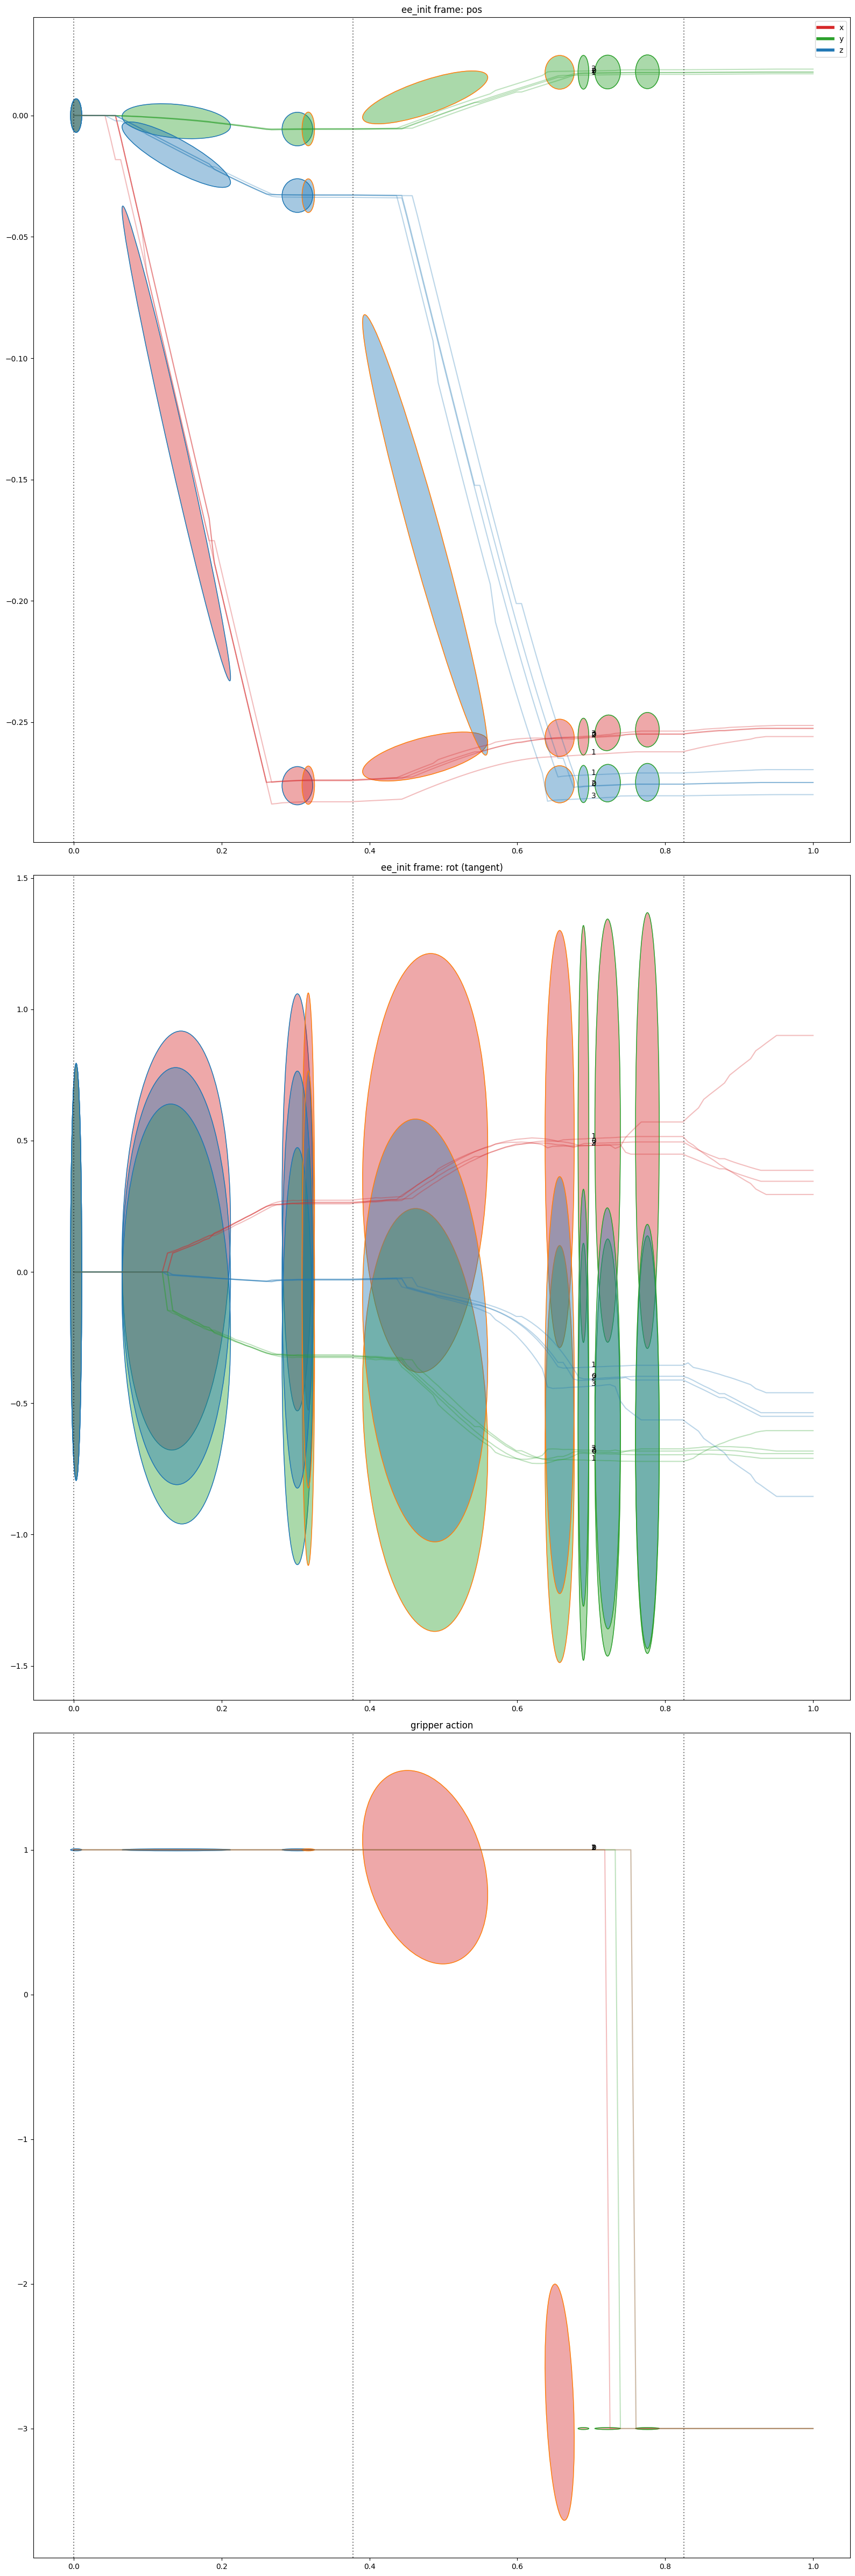

In [19]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=False, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False) #, size=(150, 10))


In [20]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       fitting_actions=(FittingStage.EM_HMM, ))


2025-06-16 21:38:51.451 | INFO     |  Fitting AutoTPGMM


Fitting segments:   0%|          | 0/3 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

((array([[1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 9.98e-001,
          7.83e-001, 4.01e-002, 1.95e-005, 1.80e-011, 2.83e-021, 7.01e-036,
          2.51e-056, 1.18e-083, 6.71e-119, 4.21e-163, 2.67e-217, 1.59e-282,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 9.98e-001,
          7.83e-001, 4.01e-002, 1.95e-005, 1.79e-011, 2.83e-021, 7.03e-036,
          2.52e-056, 1.19e-083, 8.22e-124, 1.11e-173, 2.71e-234, 1.10e-306,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.

2025-06-16 21:38:53.882 | INFO     |  Did not specify time_based, deciding automatically.


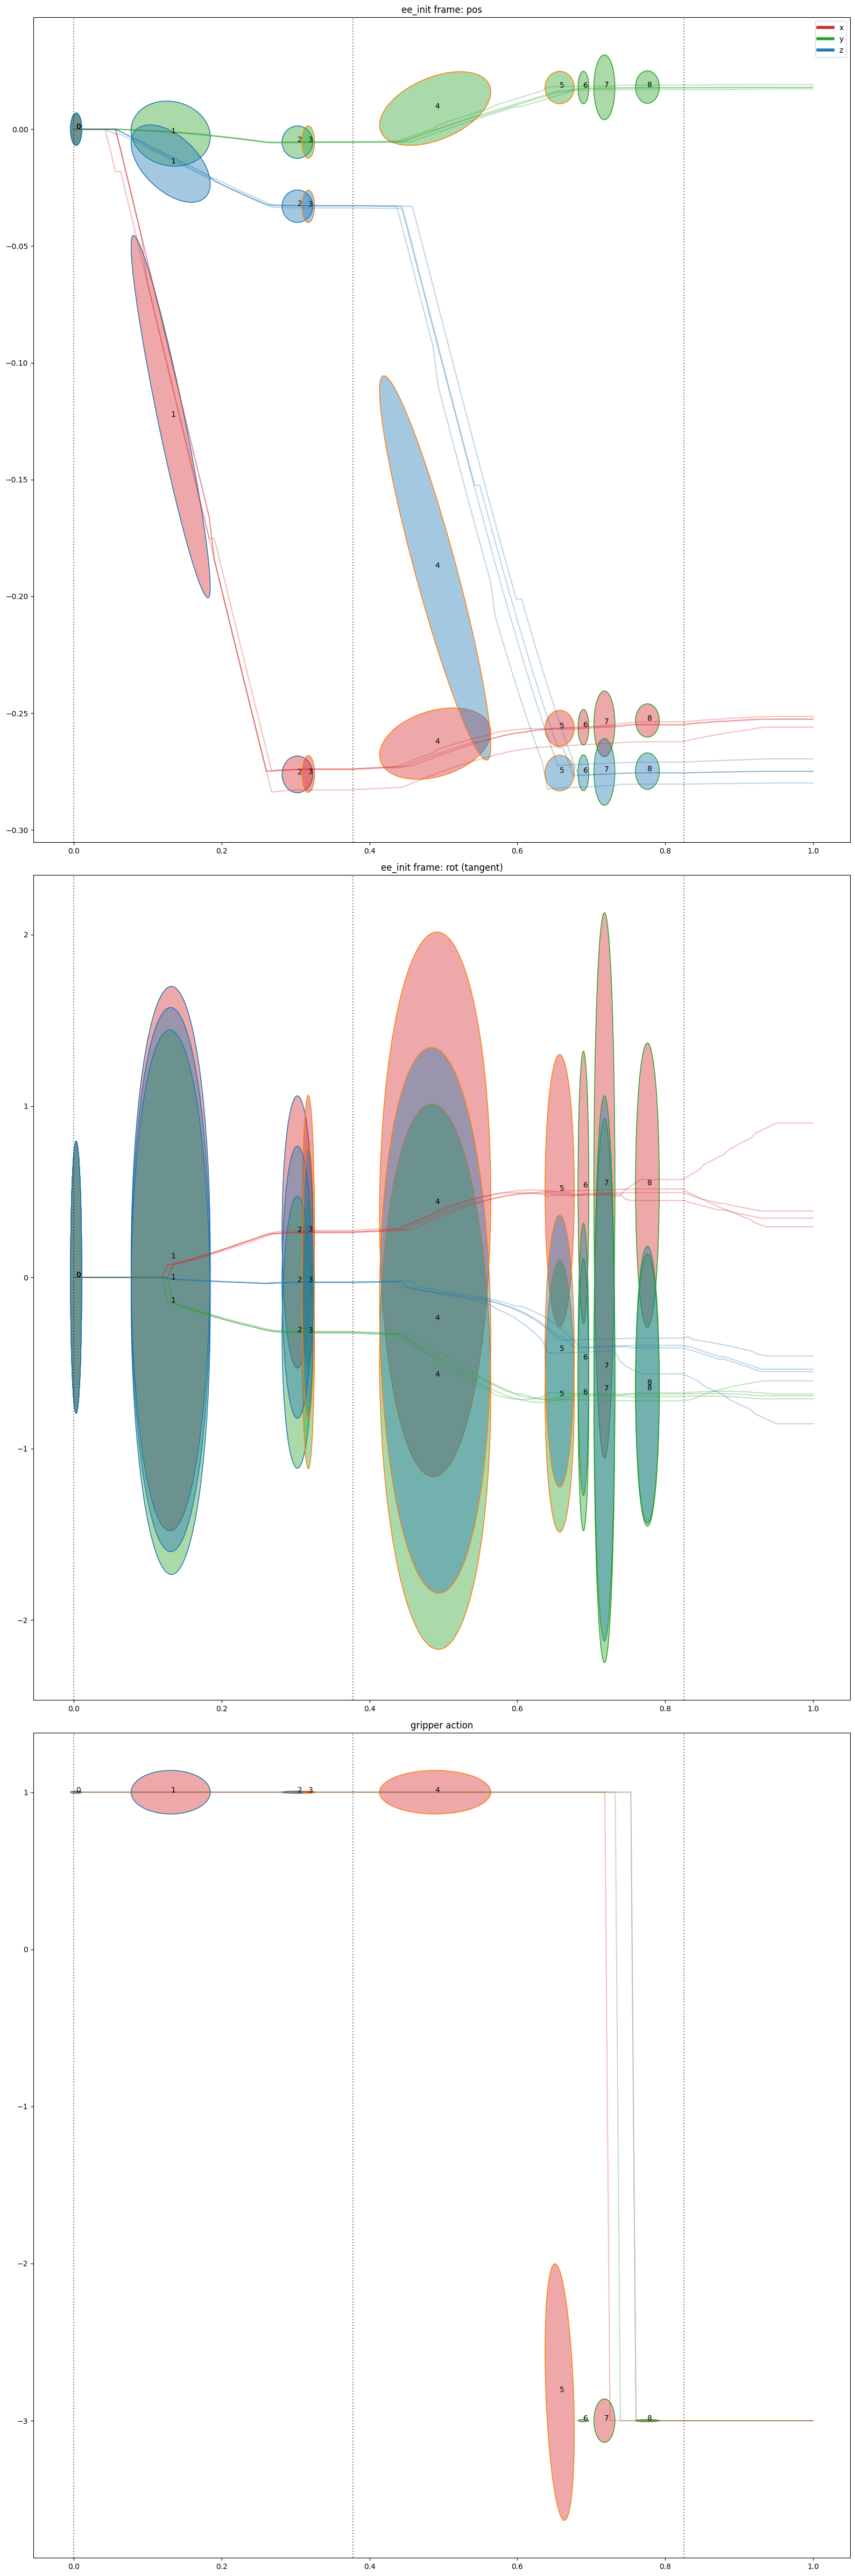

In [21]:

atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False)

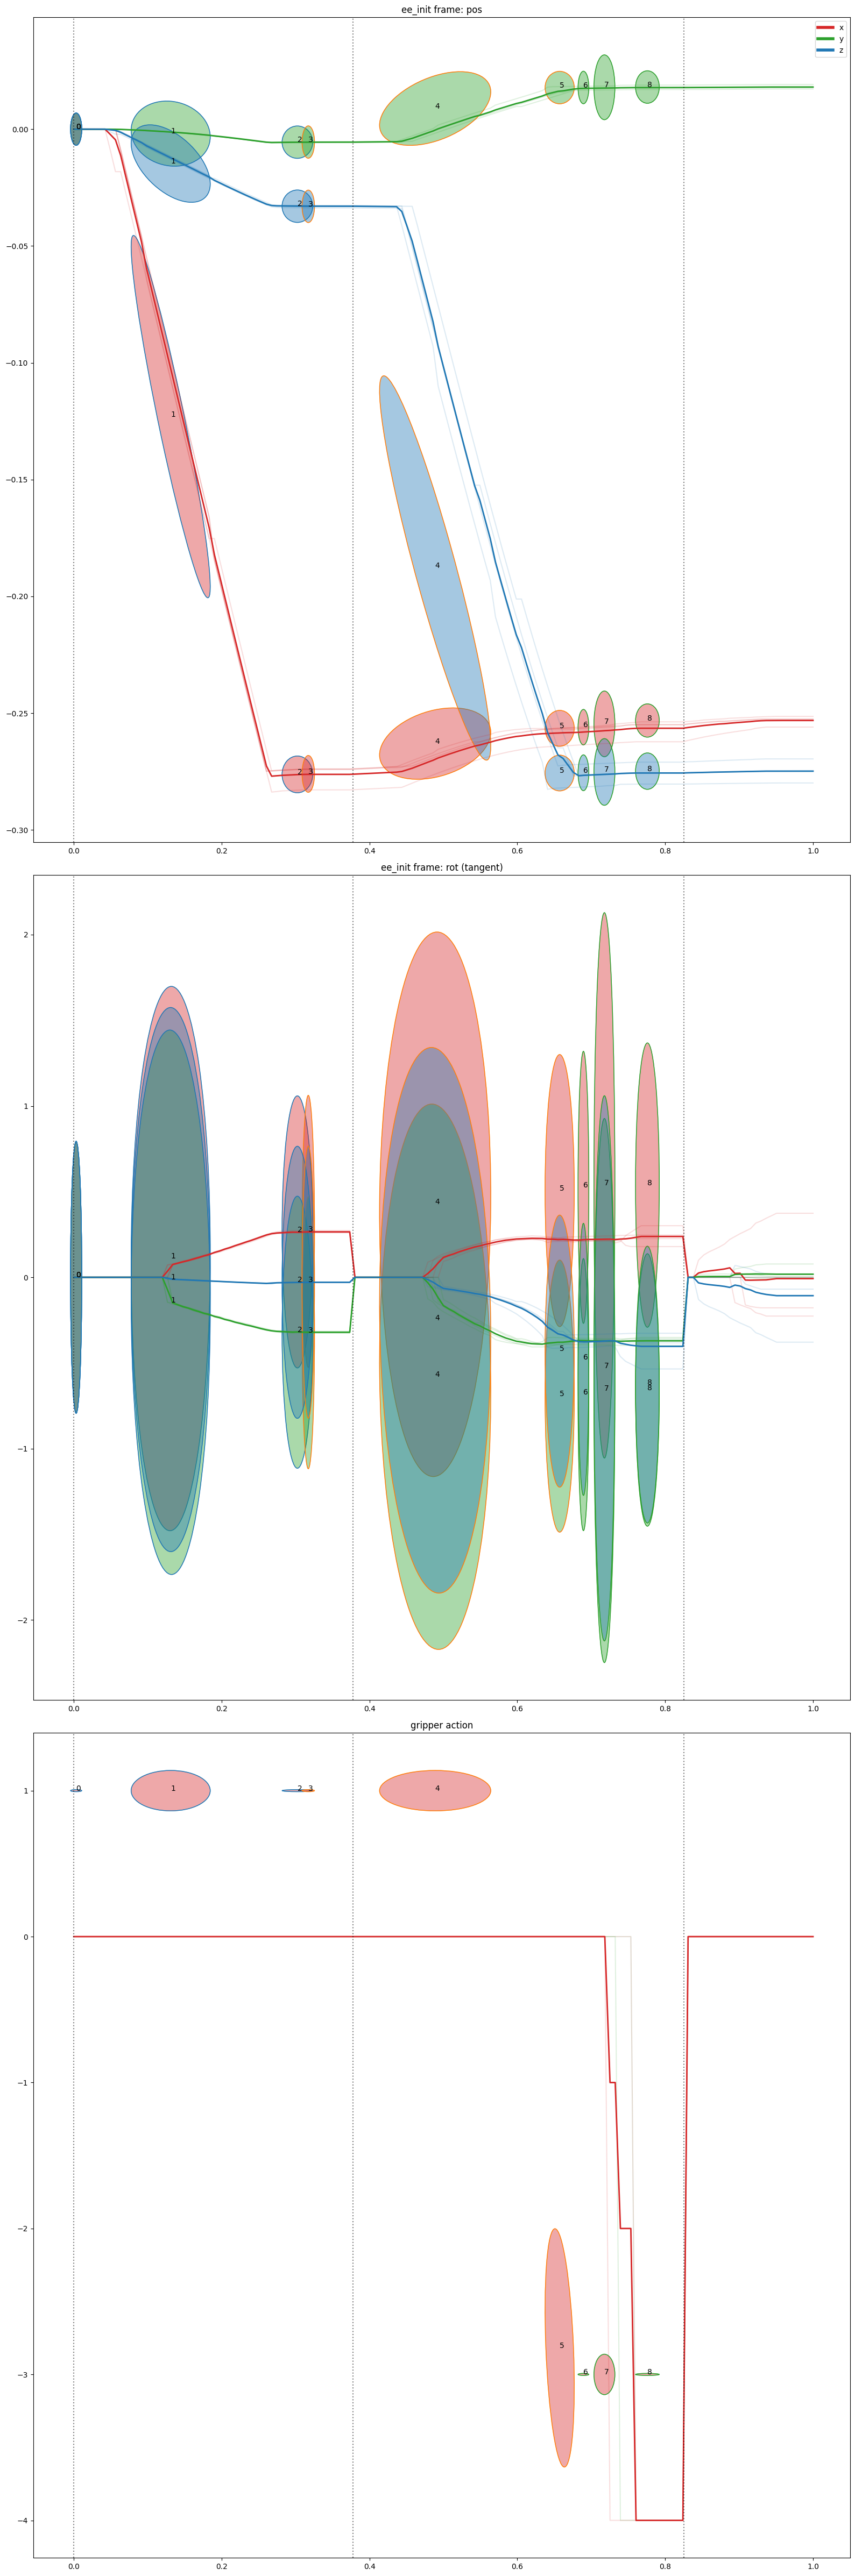

In [22]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=True, per_segment=False, gaussian_mean_only=False, plot_traj_means=True, time_based=True)

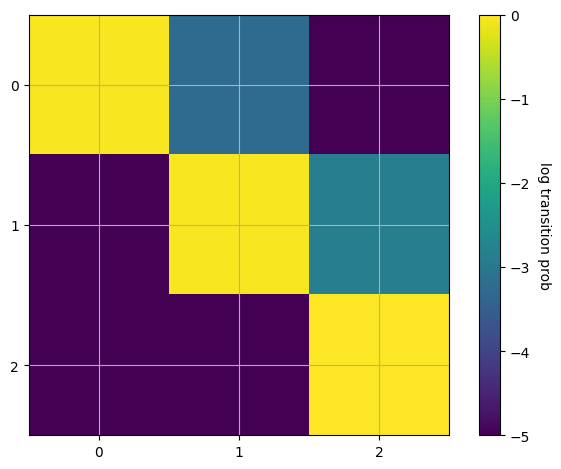

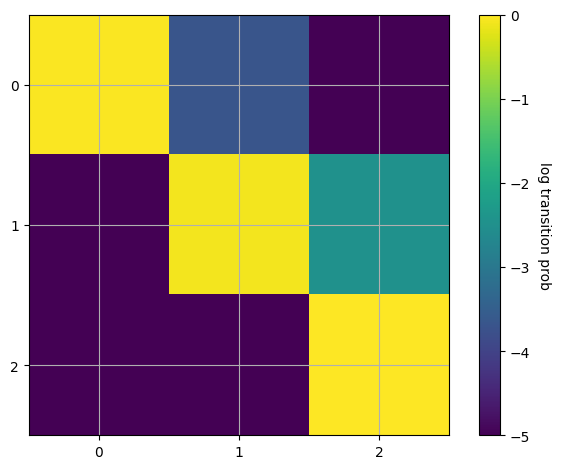

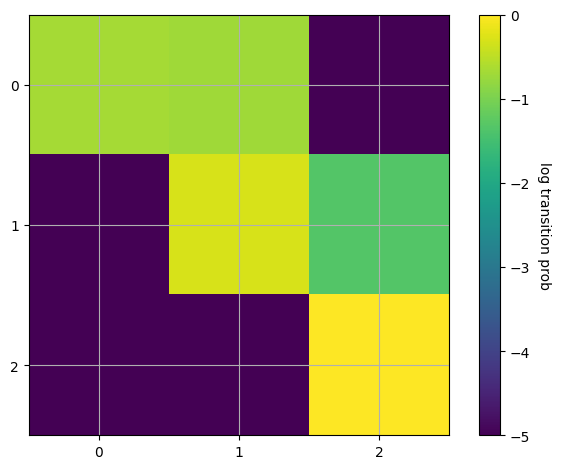

In [23]:
atpgmm.plot_hmm_transition_matrix()

In [24]:
atpgmm.to_disk(data_root / task / f'{serie}_gmm_policy-{tag}.pt')

2025-06-16 21:38:58.870 | INFO     |  Saving model:


In [25]:
seg_local_marginals, seg_trans_marginals, seg_trans_marg_container, seg_joint_models, cascaded_hmms, (reconstructions, original_trajectories, extras) = atpgmm.reconstruct(
    strategy=tapas_gmm.policy.models.tpgmm.ReconstructionStrategy.GMR,
    use_ss=False)


2025-06-16 21:38:59.036 | INFO     |  Time-based reconstruction not specified. Auto selected True.
2025-06-16 21:39:30.503 | INFO     |  Caculated segment transition probabilities: (array([[0.05]]), array([[9.84e-06]]))
2025-06-16 21:39:30.503 | WARNING  |  At least one segment transition prob below 5%. Can lead to problems.Consider increasing the diag reg.
2025-06-16 21:39:30.503 | INFO     |  Creating partial frame view of demos.
2025-06-16 21:39:30.506 | INFO     |  Assuming zero frame velocity. Should be fixed.


Transforming marginals:   0%|          | 0/4 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/4 [00:00<?, ?it/s]

2025-06-16 21:39:30.562 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/4 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/4 [00:00<?, ?it/s]

2025-06-16 21:39:30.626 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/4 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/4 [00:00<?, ?it/s]

2025-06-16 21:39:30.706 | WARNING  |  Setting init priors of later segments to zero.


GMR:   0%|          | 0/4 [00:00<?, ?it/s]

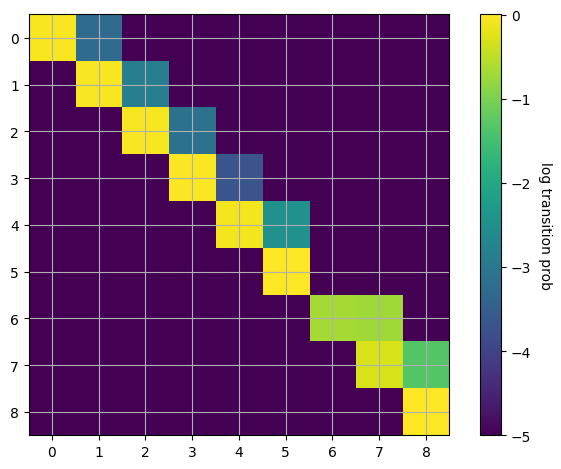

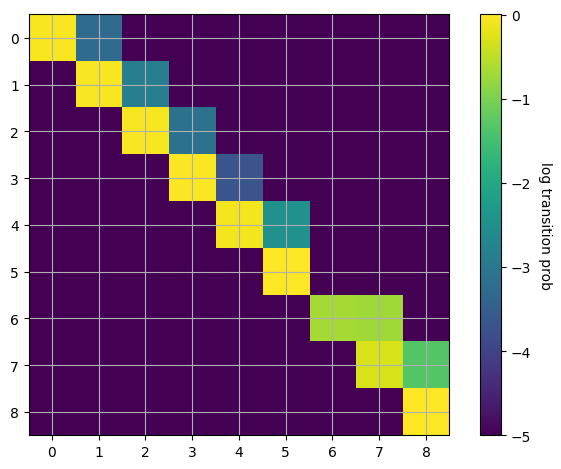

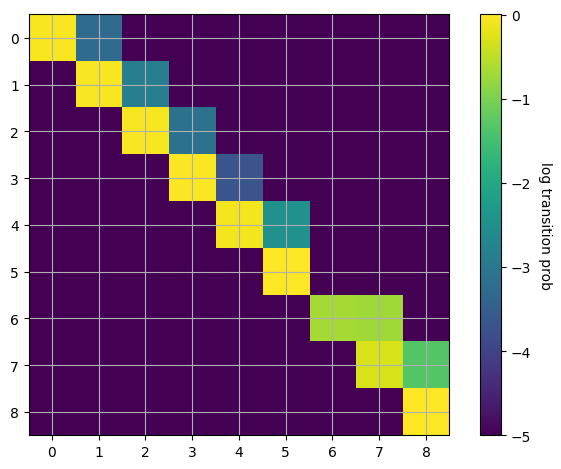

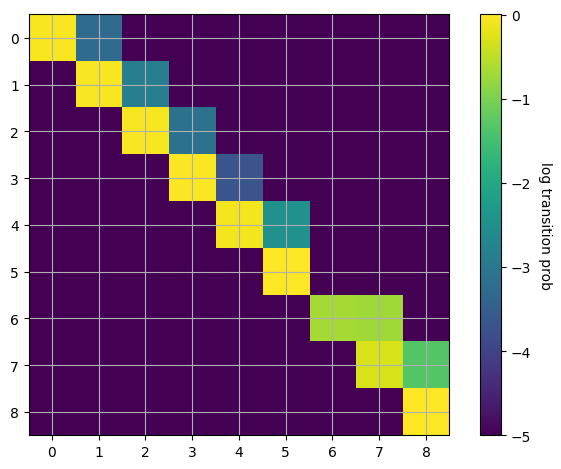

In [26]:
for cascaded_hmm in cascaded_hmms:
    plot_hmm_transition_matrix(cascaded_hmm)

2025-06-16 21:39:38.713 | INFO     |  Taking frame origins from demos.


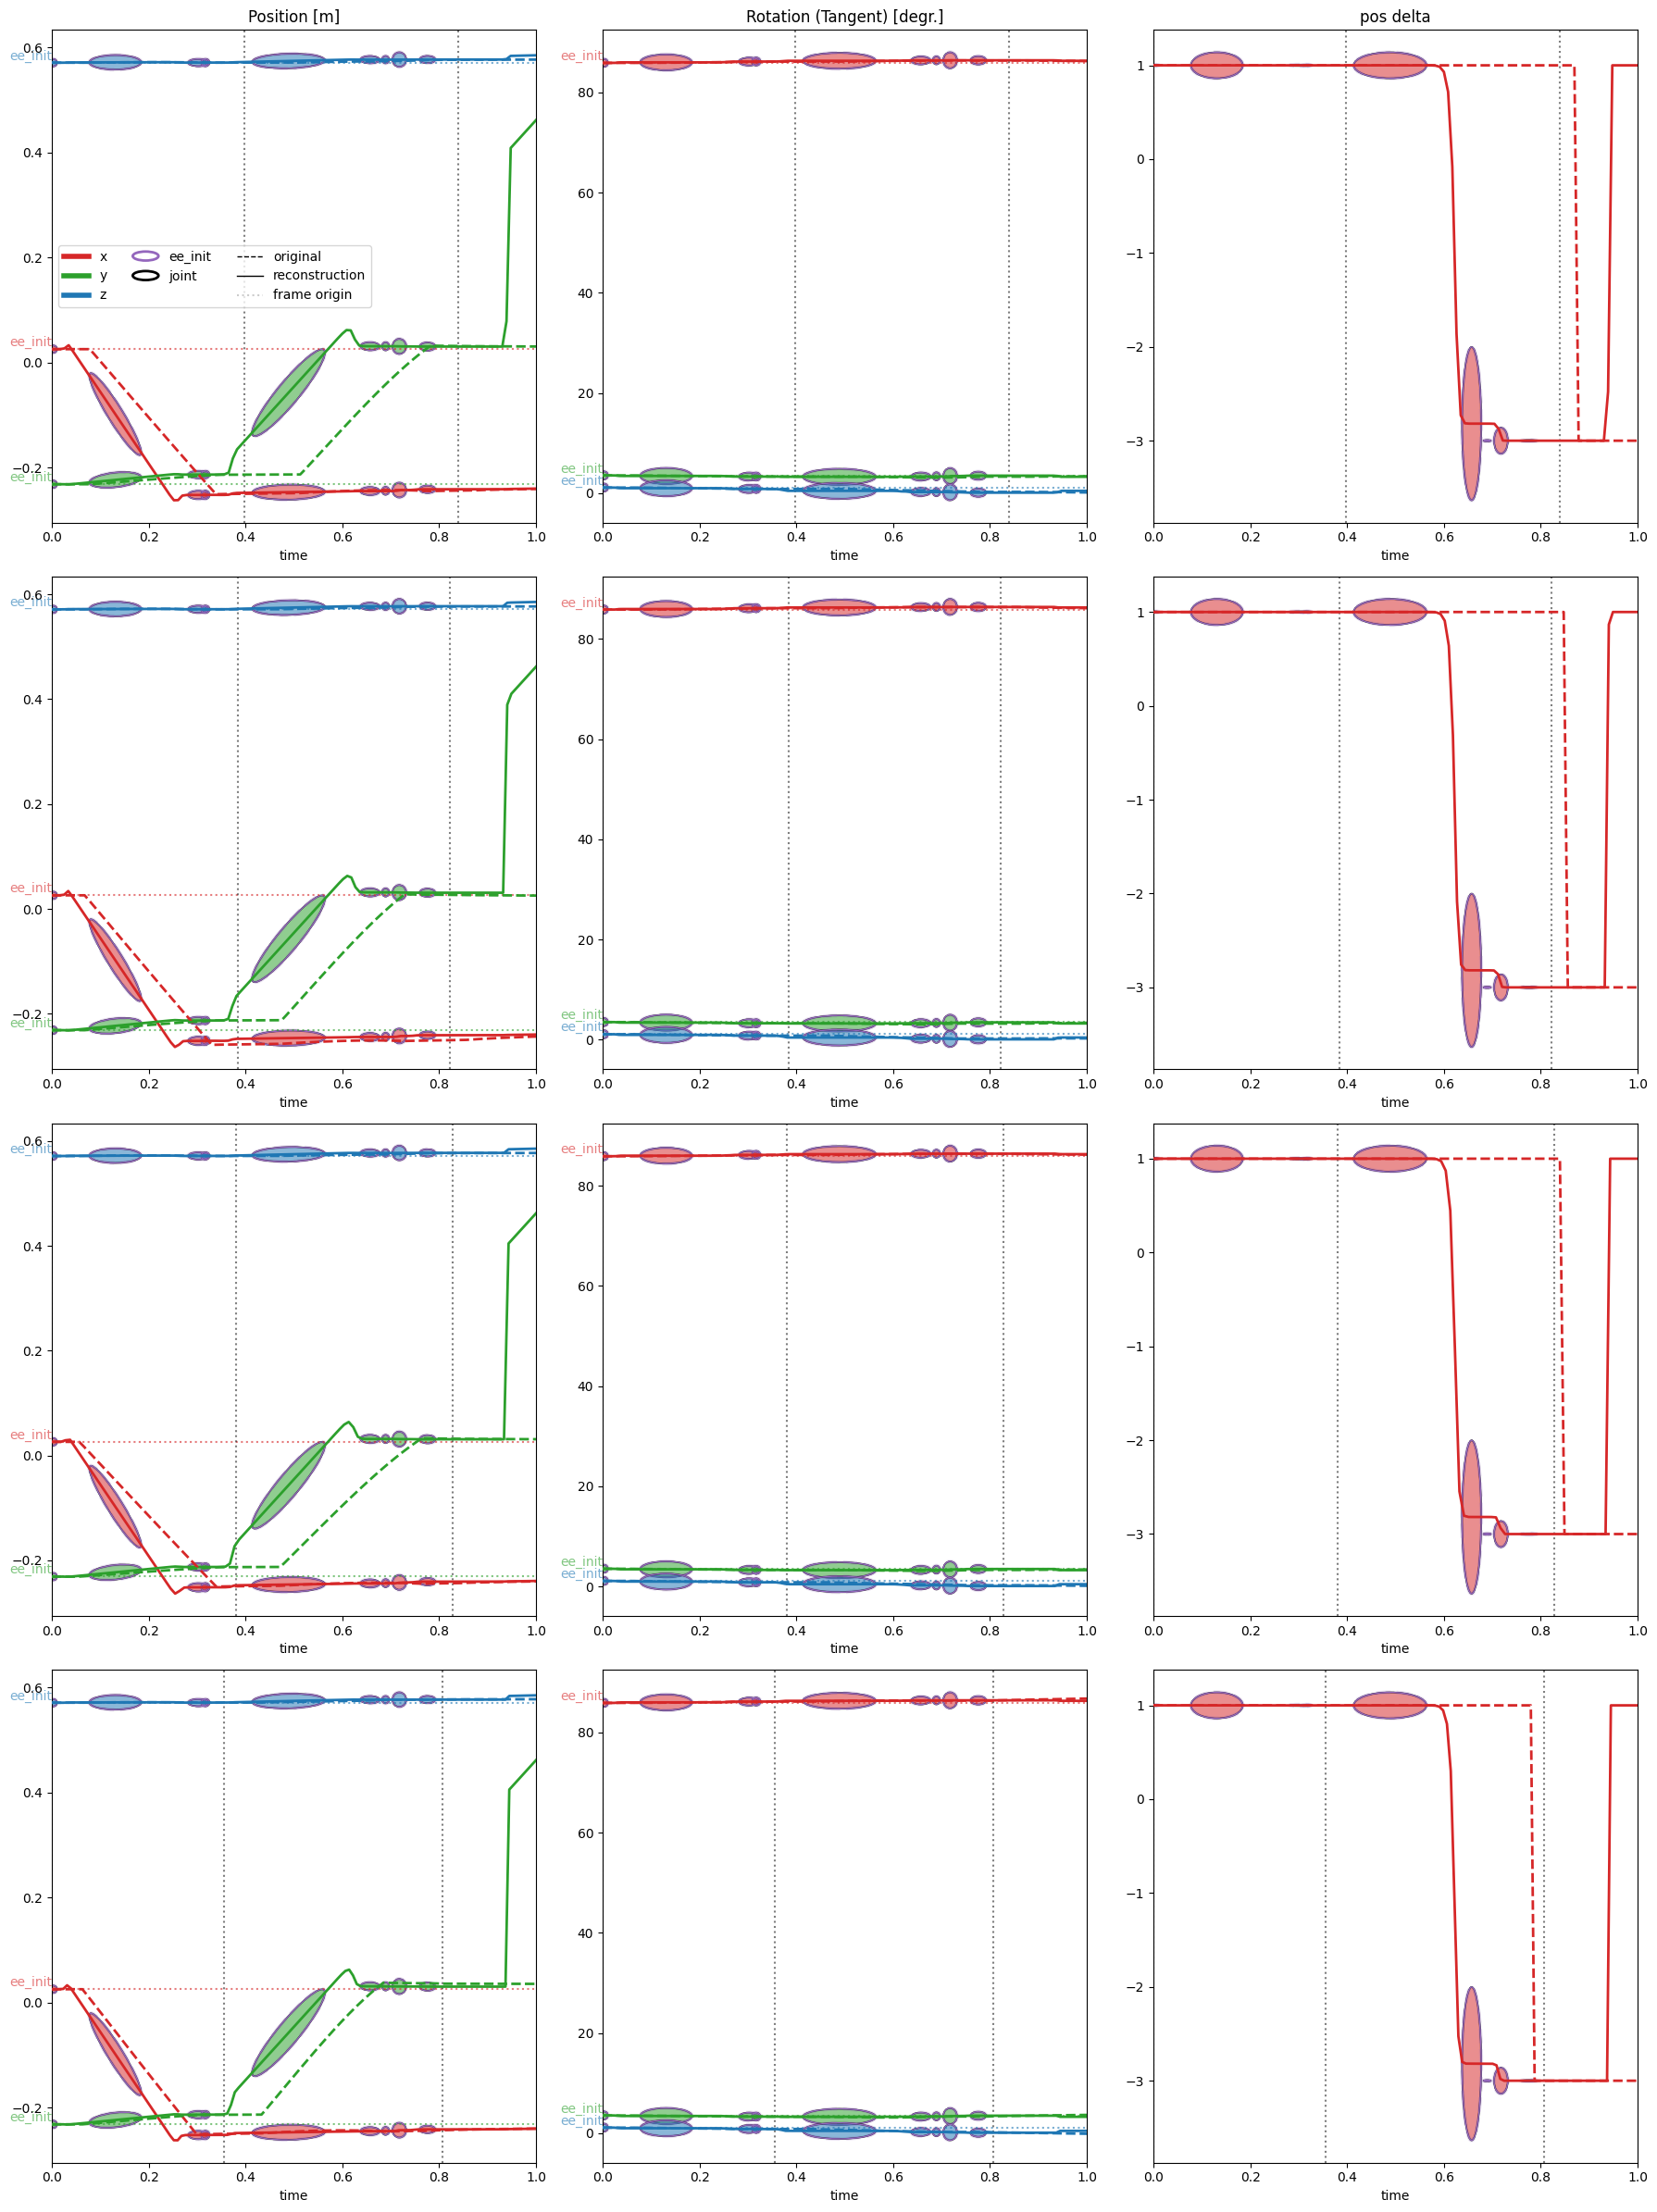

In [27]:
atpgmm.plot_reconstructions(
    seg_trans_marg_container,
    cascaded_hmms,
    reconstructions,
    original_trajectories,
    plot_trajectories=True,
    plot_reconstructions=True,
    plot_gaussians=True,
    time_based=True,
    equal_aspect=False,
    per_segment=False,
)

In [28]:
atpgmm.plot_reconstructions(
    seg_trans_marginals,
    seg_joint_models,
    reconstructions,
    original_trajectories,
    plot_trajectories=True,
    plot_reconstructions=True,
    plot_gaussians=True,
    time_based=True,
    equal_aspect=True,
    per_segment=False,
)

2025-06-16 21:39:46.477 | INFO     |  Taking frame origins from demos.


AttributeError: 'tuple' object has no attribute 'np_to_manifold_to_np'